# GAIA PSF Simulation

First attempt to simulate close binary stars observation using the gaia telescope. The latter is imagined as a rectangular pupil, with no pixel binning or aberrations

#### Initialization

In [1]:
import poppy
import numpy as np
import astropy.units as u
from astropy.table import Table
from matplotlib import pyplot as plt
from astropy import convolution as c
from simulator import GaiaTelescopeV0

/home/pietrof/miniforge3/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')



[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 5080 Laptop GPU`
[XuPy] Memory = 16231.04 MB | Compute Capability = 12.0
[XuPy] Using CuPy 13.5.1 for acceleration.


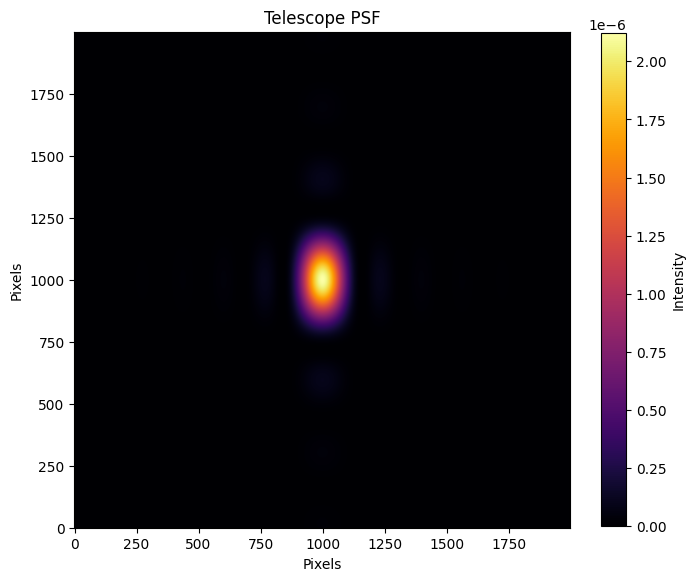

In [2]:
telescope = poppy.OpticalSystem(name="Gaia", oversample=4, verbose=True)
M1 = poppy.RectangleAperture(name="Primary Mirror", width=1.45*u.m, height=0.5*u.m)
M2 = poppy.RectangleAperture(name="Beam Collimator / Secondary Mirror",width=0.35*u.m, height=0.2*u.m)
telescope.add_pupil(M1)
telescope.add_pupil(M2)
telescope.add_detector(name="AF CCD", pixelscale=0.001*(u.arcsec/u.pixel), fov_arcsec=4*u.arcsec)
psf = telescope.calc_psf(wavelength=550e-9*u.m)
telescope_psf = poppy.utils.rebin_array(psf[0].data, (8,8))

plt.figure(figsize=(8,8))
plt.imshow(telescope_psf, origin='lower', cmap='inferno')
plt.colorbar(shrink=0.8, label='Intensity')
plt.title("Telescope PSF")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

In [ ]:
ccd = poppy.OpticalSystem(name="CCD", oversample=4, verbose=True)
ccd.add_pupil(M1)
ccd.add_detector(name="CCD", pixelscale=0.059*(u.arcsec/u.pixel), fov_arcsec=(0.059*4500,1966*0.177))

psf_ccd = ccd.calc_psf(wavelength=650e-9*u.m)
ccd_psf = psf_ccd[0].data
#ccd_psf = poppy.utils.rebin_array(psf_ccd[0].data, (32,32))

plt.figure(figsize=(8,8))
plt.imshow(ccd_psf, origin='lower', cmap='inferno')
plt.colorbar(shrink=0.8, label='Intensity')
plt.title("CCD PSF")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()